---
<div align="center">
    
# S&P-500 | Stock Forecasting and Optimization
</div>

---

---
<div align="center">
    
## Problem Formulation
</div>

---

### Context

> ADD CONTEXT

### Resolution Approach

> ADD A RESOLUTION APPROACH

### Planned Work

> ADD A PLANNED WORK

---
<div align="center">
    
## Project Dependencies

</div>

---

In [1]:
# !pip install requests-cache requests-ratelimiter
# !pip install --upgrade yfinance

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Importing Dependencies
import numpy as np
import pandas as pd

# Import json to help save dictionaries into .json files
import json

# Import matplotlib to help visualize the data
import matplotlib.pyplot as plt

# Import Datetime to properly format the Dates from the Dataset
from datetime import (datetime, timedelta)

# Importing an API to handle the Datset from Yahoo Finance
import yfinance as yf
from yfinance import (Ticker)

# Import a Sequential Model from tensorflow alongside the Adam Optimizer and layers
from tensorflow.keras.models import (Sequential)
from tensorflow.keras.optimizers import (Adam)
from tensorflow.keras import (layers)

from DataPreProcessing.DataExtraction import (extractSP500StocksInformationWikipedia, getSP500StockMarketInformation, getStockMarketInformation)
from DataPreProcessing.DataVisualization import (plotStockClosingPrice)

from Utils.Configuration import (loadConfig, loadPathsConfig)

In [5]:
# Load the configs
config = loadConfig()
pathsConfig = loadPathsConfig()

---
<div align="center">

## Data Preprocessing
</div>

---

In [6]:
# dataset aquired @ https://www.nasdaq.com/market-activity/stocks/screener
# It consists of all the publicly available stocks globally
worldWideStocks = pd.read_csv('./Datasets/Stocks.csv')
worldWideStocks.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$139.65,2.780,2.031%,4.012531e+10,United States,1999.0,1795434,Industrials,Biotechnology: Laboratory Analytical Instruments
1,AA,Alcoa Corporation Common Stock,$40.73,0.160,0.394%,1.052279e+10,United States,2016.0,2930997,Industrials,Aluminum
2,AACG,ATA Creativity Global American Depositary Shares,$1.04,0.030,2.97%,3.328014e+07,China,2008.0,64843,Real Estate,Other Consumer Services
3,AACT,Ares Acquisition Corporation II Class A Ordina...,$10.87,-0.005,-0.046%,0.000000e+00,NaN,2023.0,26869,Finance,Blank Checks
4,AADI,Aadi Bioscience Inc. Common Stock,$1.96,-0.030,-1.508%,4.824508e+07,United States,NaN,24640,Health Care,Biotechnology: Pharmaceutical Preparations


In [7]:
# Extract some information of the S&P-500 Stocks from wikipedia
sp500Stocks = extractSP500StocksInformationWikipedia(pathsConfig)

# Compute the unique stocks
uniqueStocks = np.unique(sp500Stocks.Symbol.to_numpy())
print(f"There are {uniqueStocks.size} Unique Stocks out of {sp500Stocks.shape[0]} total Available Stocks on the S&P 500 Program.")

There are 503 Unique Stocks out of 503 total Available Stocks on the S&P 500 Program.


Which means that each row corresponds to a different stock.

In [8]:
# Inspect the DataFrame
sp500Stocks.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",2000-06-05,1090872,1999
1,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
2,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABNB,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines","San Francisco, California",2023-09-18,1559720,2008
4,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888


In [9]:
# Extract a S&P-500 Stock Market Information
sp500MarketHistory = getSP500StockMarketInformation(config=config, pathsConfig=pathsConfig)

# Inpect the DataFrame
sp500MarketHistory.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3991400000,0.0,0.0,0.016043
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2491020000,0.0,0.0,0.003116
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4972660000,0.0,0.0,0.000546
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5270680000,0.0,0.0,0.004001
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4389590000,0.0,0.0,0.002882


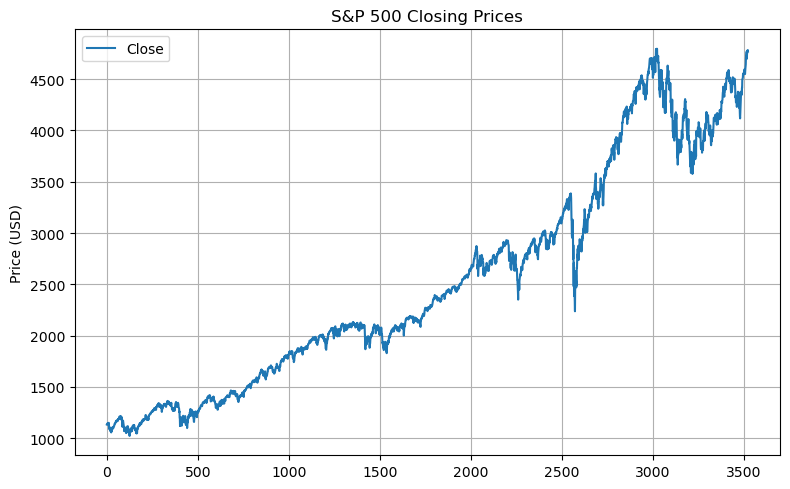

In [10]:
# Let's see a historical view of the closing price
plotStockClosingPrice(stockMarketHistory=sp500MarketHistory, title='S&P 500 Closing Prices')

In [11]:
# EXAMPLE ON HOW TO EXTRACT A STOCK'S MARKET INFORMATION INTO A DATAFRAME

# Extract a Stock's Market Information
stockMarketHistory = getStockMarketInformation(stockSymbol='NVDA', config=config, pathsConfig=pathsConfig)

# Inpect the DataFrame
stockMarketHistory.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,EMA,UpperBB,LowerBB,Daily Return,Cumulative Return,Covariance,Beta
0,2010-01-04,0.424410,0.426933,0.415239,0.423952,800204000,0.0,0.0,0.386383,0.388421,0.448434,0.324333,-0.010171,1.324498,0.000134,1.381303
1,2010-01-05,0.422347,0.434728,0.422347,0.430143,728648000,0.0,0.0,0.391542,0.392395,0.449835,0.333250,0.014602,1.343839,0.000134,1.391743
2,2010-01-06,0.429913,0.433811,0.425786,0.432894,649168000,0.0,0.0,0.394741,0.396252,0.454801,0.334681,0.006396,1.352435,0.000134,1.390998
3,2010-01-07,0.430601,0.432436,0.421200,0.424410,547792000,0.0,0.0,0.398409,0.398934,0.456148,0.340670,-0.019597,1.325931,0.000133,1.385121
4,2010-01-08,0.420971,0.428308,0.418449,0.425328,478168000,0.0,0.0,0.401688,0.401447,0.457603,0.345773,0.002161,1.328796,0.000133,1.380418


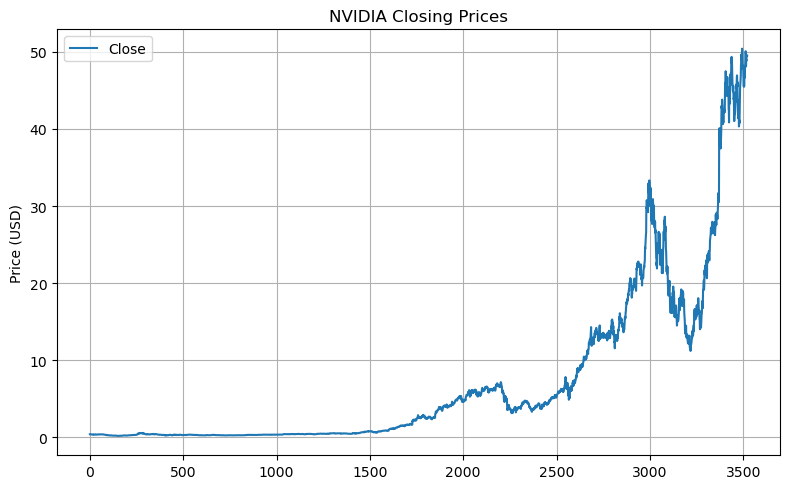

In [12]:
# Plotting the NVIDIA Closing Prices over the years
plotStockClosingPrice(stockMarketHistory=stockMarketHistory, title='NVIDIA Closing Prices')

In [13]:
# Extract the market informations for all stocks
# for symbol in sp500Stocks.Symbol:
#     X = getStockMarketInformation(stockSymbol=symbol, config=config, pathsConfig=pathsConfig)
#     if X is None:
#         print("Failed", symbol)
#         break
#     else:
#         print(f"Processed {symbol}")

<div align="center">
    
---
## Conclusions
---
</div>

> ADD CONCLUSIONS

<div align="center">

---
## Bibliographic References
---
</div>

1. AUTHOR (YEAR). __*TITLE*__. Available [here](_LINK_)

LINKS:
- https://medium.com/@kasperjuunge/yfinance-10-ways-to-analyze-stock-prices-18d2062ab35c

___
## Video Presentation (YouTube Video)

Moreover, you can find the **Video** for our **Project's Presentation [here](https://youtu.be/dQw4w9WgXcQ?si=M2fOqMOebz5GcYoj)**
___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Francisco Macieira](https://github.com/franciscovmacieira) &#8594; `up202207166@edu.fc.up.pt`
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@edu.fc.up.pt`